<center><h1>ECSE 443: Introduction to Numerical Analysis in Electrical Engineering</h1></center>
<center><h3>Assignment 0: Errors in numerical analysis</h3></center>
<center><h3>Due: Friday, January 20<sup>th</sup>, 2020 at 11:59pm EST on <a href='https://mycourses2.mcgill.ca/'>myCourses</a></h3></center>
<center><h3>Final weight: 0%</h3></center>

# Assignment submission process

Download and modify the ipynb notebook we provide on myCourses and submit your modified file, renamed according to your student id as -

<font color='red'>[YourStudentId].ipynb</font>

For example, if your id is **234567890**, your submission filename should be **234567890.ipynb**.

Note that every time you submit a new file, your previous sumbission will be overwritten. **All submissions must be made using myCourses**.

## Late policy :  non-negotiable time-based penalty

This assignment is to be completed individually.

<font color='red'>You will lose **5% per hour** on the assignment past the deadline, up to a maximum of -100%.</font>

## Import statements

We provide the import statements required to complete the assignment in the following cell. 

<font color='red'>Import policy: You must not use any other imports other than the ones provided. Doing so will result in a score of **zero (0%)** in the assignment.</font>

<font color='blue'>**Run** the following cell to include the needed modules.</font>

In [1]:
from numpy import array, arange, zeros, linspace, roll           # array and array manipulation
from numpy import log, exp, sum, average, max, abs, cos, sin, pi # math functions
from numpy import float32, float64, int32                        # data type conversion
import matplotlib.pyplot as plt                                  # plotting 
from numpy.random import normal                                  # random numbers

# Computer arithmetic

We will learn about errors due to fixed precision floating point representations. We will face these limitations in the implementation of several simple numerical algorithms.

## Learning objectives
1. Loss of significant digits due to *difference in scales* and *catastrophic cancellation*:

  a. Summing numbers with different scales, e.g., $10^{38} + 10^{-24}$.

  b. Catastrophic cancellation, e.g., $1.38383\times 10^{38}  - 1.38382\times 10^{38}$. 

2. Error accumulation due to *round-offs* during operations on lengthy floating point sequences, e.g., $\displaystyle\sum\limits_{i=0}^{10^{38}}1.0$

3. *Overflow* and *underflow*, e.g., $10^{24} \times 10^{10}$.

<font color='dark pink'>In Python, unlike other languages like C/C++/Java, any expression containing an integer and floating point arithmetic is automatically cast to the high precision (64-bit) floating point to avoid loss of precision due to conversions from integer to floating point.</font>

<font color='blue'>For this assignment, we ask that you **explicitly cast values to float32** before using them in an expression containing mixed floating point and integer variables.</font>

The following *code excerpt* illustrates this issue

In [2]:
K = 10              # integer
f = float32(6.4)    # 32-bit float

val1 = f/K          # default - val is evaluated with 64-bit precsion 
val2 = f/float32(K) # forced - val is evaluated with 32-bit precision

print("default integer-float32 arithmetic:") # output: default integer-float32 arithmetic:
print(type(val1))                            # output: <class 'numpy.float64'="">
print("forced integer-float32 arithmetic:")  # output: forced integer-float32 arithmetic:
print(type(val2))                            # output: <class 'numpy.float32'="">

default integer-float32 arithmetic:
<class 'numpy.float64'>
forced integer-float32 arithmetic:
<class 'numpy.float32'>


## Floating point system

A <u>*floating point system*</u> can be characterized by four values $(\beta,\, t,\, L,\, U)$, where
* $\beta$ is the base of the number system,
* $t$ is the precision (i.e. number of digits),
* $L$ is the lower bound on exponent $e$ and 
* $U$ is the upper bound on exponent $e$.

In such a system, we write a number $x$ in it's floating point representation $\mathrm{fl}(x)$ as:

$$\mathrm{fl}(x) = \underbrace{\pm}_{\text{sign}}\displaystyle\left( \underbrace{\frac{\tilde{d}_0}{\beta^0} + \frac{\tilde{d}_1}{\beta^1} + \cdots +\frac{\tilde{d}_{t-1}}{\beta^{t-1}}  }_{\text{mantisse}} \right)\times\underbrace{\beta^e}_{\text{exponent}}$$

where the base $\beta$ is an integer greater than 1 and $\tilde{d}_i$ are integer digits in the range $0\le \tilde{d}_i\leq\beta-1$. The number $\mathrm{fl}(x)$ is an approximation of $x$. To ensure uniqueness of this representation, it is normalized to satisfy $\tilde{d}_0 \neq 0$ by adjusting the *exponent* $e$ so that leading zeros are dropped. In addition, $e$ must be in the range $L \leq e \leq U$.


<font color='blue'>The following code generates all possible floating point numbers that can be perfectly represented by the parameterized floating point system characterized above. **Read** and **run** the following cell to better understand the fixed precision floating point system.</font>

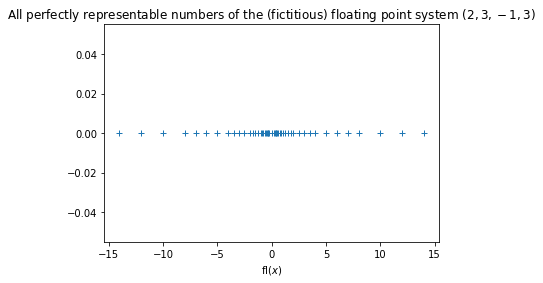

In [3]:
def FloatPointSystem(beta, t, L, U):

  # smallest possible number in the mantissa, (1.00...0)_beta, expressed in base 10
  smallest = 1*beta**0 # 1.00

  # largest possible number in the mantissa, (beta-1. beta-1  beta-1... beta-1)_beta, expressed in base 10
  largest = sum([ (beta-1) * beta**-k for k in range(0,t)])

  # special case: add 0 to the list
  x = [0]

  # loop over all possible mantissa numbers
  step =  beta**(1-t)
  for mantissa in arange(smallest, largest + step, step):
    # loop over all possible exponents
    for exponent in range(L, U+1):
      # add both positive and negative numbers due to the settings of the sign bit
      tok = mantissa * beta**exponent
      x.append(tok)
      x.append(-tok)
  
  # (Optional) sort the entries for plotting purposes
  x.sort()
  
  # return the list
  return x

# Instantiate a fictitious floating point system with parameters (beta, t, L, U) = (2,3,-2,3)
beta, t, L, U = (2,3,-2,3)
x = FloatPointSystem(beta, t, L, U)

# Plot a + at each perfectly representable value along the real line
y = zeros(len(x));
plt.plot(x ,y, '+')
plt.xlabel('$\mathrm{fl}(x)$')
plt.title('All perfectly representable numbers of the (fictitious) floating point system $(2,3,-1,3)$')
plt.show();

## Task 1 - Finite differences

A common approach to approximate the first derivative $f'(x)$ of a function $f(x)$ is to use the *finite difference* method, which can be derived using the first-order terms of the Taylor series expansion of the function, about $x_0$: $f(x_0) = f(x_0 + h) + hf'(x_0) + \mathcal{O}(h^2)$.

Rearranging terms to solve for $f'$ -- and dropping the higher-order terms -- yields the first-order finite difference approximation:

$$f'(x_0) \approx \frac{f(x_0 + h) - f(x_0)}{h}$$

<font color='blue'>Your task is to **implement this finite difference approximation of $f'(x)$ for $f(x) = \sin(x)$**, in the cell, below:</font>

In [26]:
def finiteDifference(x_0, h):
    ret = 0
    # YOUR CODE HERE
    num = sin(x_0 + h) - sin(x_0)
    ret = float32(num) / float32(h)
    #raise NotImplementedError()
    
    return ret

The *numerical error* of this finite difference approximation is given by

$$\left\lvert f'(x) - \frac{f(x+h) - f(x)}{h}\right\rvert ,$$

where -- in this example -- we have the luxury of computing an analytically-correct $f'(x)$ as $f'(x) = \cos(x)$.

<font color='blue'>**`Run`** the following cell.</font>


In [27]:
def numericalError(x_0, h):
    return abs(cos(x_0) - finiteDifference(x_0, h))

We can also approximate the *discretization error* analytically as $\left\lvert {h f''(x)}\big/{2}\right\rvert ,$
where $f''(x) = -\sin(x)$.

<font color='blue'>**`Run`** the following cell.</font>

In [28]:
def discretizationError(x_0, h):
    return h * abs(sin(x_0)) / 2.0 

<font color='blue'>**`Run`** the following cell to explore the interplay between the round-off and discretization errors. You should observe that, as $h$ decreases, round-off errors dominate.</font>

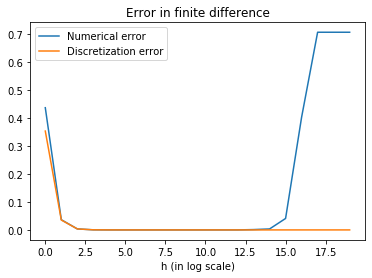

In [29]:
# Compute the finite difference approximations at a fixed x_0
x_0 = pi/4

# Step size for h, in log scale
log_h = [i for i in range(0, 20)]

errorNumerical = [numericalError(x_0, 10**(-i)) for i in range(0, 20)]
errorDiscrete = [discretizationError(x_0, 10**(-i)) for i in range(0, 20)]

plt.plot(log_h, errorNumerical, label="Numerical error")
plt.plot(log_h, errorDiscrete, label="Discretization error")
plt.xlabel("h (in log scale)")
plt.title("Error in finite difference")
plt.legend()
plt.show()   

In [30]:
x_0 = 3.141 / 10
h = 25
assert (finiteDifference(x_0, h) + 0.005143) < 1e-4

## Task 2 - Log sum of exponentials

### Naive formulation
We wish to evaluate the log of the sum of exponentials of a set of $N$ values $x_i$, as defined by the following expression:

$$y = \log \displaystyle\left(\sum\limits_{i=1}^{N} \exp(x_i)\right)~.$$

Computing this expression naively may cause the exponential term within the summation to overflow.

<font color='blue'>We provide the naive implementation, below. **`Run`** the following cell.</font>

In [31]:
# x is a `numpy` array of the $N$ values $x_i$
def LogSumExpNaive(x):
  return log(sum(exp(x)))

### Alternative formulation

Using logarithmic/exponential identities, we can improve arithmetic stability. First, we find the maximum value: 

$$m= \underset{x}{\operatorname{argmax}} x_i$$

before offsetting the computation into a more stable operating range, as $y = m + \log \displaystyle\left(\sum\limits_{i=1}^{N} \exp(x_i - m)\right)$.

With this formulation, the largest value passed to the exponential function is $0$. If there are large negative values after subtraction, they will become zero after exponentiation -- as they *should* given limited precision arithmetic operations.

<font color='blue'>Your task is to **implement the more stable formulation** described above.</font> 

In [43]:
def LogSumExpAlternative(x):
    ret = 0
    # YOUR CODE HERE
    m = max(x)
    summation = 0
    for element in x:
        summation = summation + exp(element - m)
    ret = m + log(summation)
    #raise NotImplementedError()
  
    return ret

<font color='blue'>**`Run`** the following cell to compare the alternative formulation with the naive approach</font>

In [44]:
x = array([1000,988,1298,1100])

y_1 = LogSumExpNaive(x)
y_2 = LogSumExpAlternative(x)

print("Naive computation: {} \n".format(y_1))
print("Alternative computation: {} \n".format(y_2))

Naive computation: inf 

Alternative computation: 1298.0 



/Users/liuxijun/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
x = array([1000,988,1298,1100])
y = LogSumExpAlternative(x)
assert (y - 1298.0) < 1e-5

## Task 3 - Iterative approximation of an integral
We will explore two numerical approaches for computing the following integral, parameterized by $n$:

$$I_n = \displaystyle\int_0^1 f(x,\,n) \, d x = \displaystyle\int_0^1 \frac{x^n}{x+10} \, d x~.$$

### Baseline - Riemann sum

Fist, we provide code for a baseline approximating of the integral using a *Riemann sum*. 
The Riemann sum of $f(x,\,n)$ over $[0,1]$ is
$$I_n \approx \displaystyle\sum_{k=0}^{M-1} f\left(\left[\frac{1}{2}+k\right]\Delta x,\, n\right) \Delta x$$
where $\Delta x = {1}\big/{M}$ and $M$ is the number of discrete points. This discretization is computationally expensive but numerically stable.

<font color='blue'>We provide you with the code for the Riemann sum, with $M = 10$. **`Run`** the following cell.</font>

In [45]:
def riemann(N): 
  
  if N == 0:
    return log(11) - log(10)
  
  f = lambda x, k: x**k / (x+10)
  
  M = 10
  dx = 1/M
  x = linspace(dx/2, 1-dx/2, M)
  return sum(f(x, N)) * dx

### Alternative - Recursive formulation

Recursively applying *integration by part* yields the following closed form recursive solution for the integral:
$$I_n = \begin{cases}
\ln(11)-\ln(10) & \text{ for } n=0\\
{1}\big/{n}- 10 \, I_{n-1} & \text{ for } n\geq1
\end{cases}~.$$
The recursive formulation is numerically less stable but much more computationally efficient than the Riemann sum.

<font color='blue'>Your task is to **implement this recursive formulation**.</font>

In [48]:
def recursive(N):
    ret = 0
    
    # YOUR CODE HERE
    if N == 0:
        ret = log(11) - log(10)
    else: 
        ret = 1/N - 10 * recursive(N - 1)
#     raise NotImplementedError()
    return ret

 <font color='blue'>**`Run`** the following cell to compare the recursive formulation against the baseline.</font>

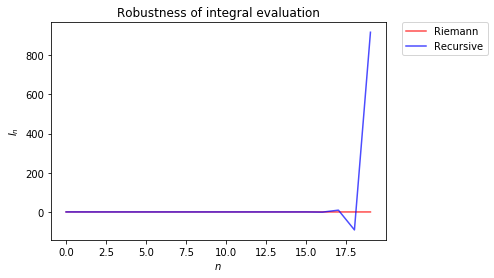

In [49]:
y_1 = []
y_2 = []
for i in range(20):
  y_1.append(riemann(i))
  y_2.append(recursive(i))

plt.plot(y_1, 'r', label="Riemann", alpha=0.7)
plt.plot(y_2, 'b', label="Recursive", alpha=0.7)
plt.xlabel('$n$')
plt.ylabel('$I_n$')
plt.title('Robustness of integral evaluation')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show();

In [51]:
assert (recursive(5) - 0.0153529) < 1e-5

## Task 4 - Computing a moving average

We will compute the *moving average* -- over a window of size $K$ -- of a stream of randomly generated values. Some examples of such a moving average include the frame rate counters in video games or the average speed of a car over the last few seconds.  

Like previous tasks, we provide you with two different methods to achieve the same goal but with distinct trade-offs.

### Naive method

Here we simply compute the average of last $K$ samples at every time step:

$$\mu_t = \displaystyle\sum\limits_{i = t-K +1}^{t}a_i~.$$

This method is more numerically stable but requires more computation, since the average is completely recomputed -- i.e., over all $K$ samples -- at each step.

<font color='blue'>We provide you with the code for the naive method. **`Run`** the following cell.</font>

In [52]:
def MovAvgNaive(samples, K):
  window_t = zeros(K, dtype=float32)
  movingAvg = []
    
  for sample in samples:
    window_t = roll(window_t, -1)
    
    # place the latest element to the right of the window
    window_t[-1] = sample
    
    mu_t = float32(0)
    
    for subsample in  window_t:
      mu_t += subsample
    
    mu_t /= float32(K)
    movingAvg.append(mu_t)

  return movingAvg

### The efficient method 

The idea here is to update the average from its previous value by adding and subtracting the newest and oldest samples from sliding window:

$$\mu_t = \mu_{t-1} + \frac{a_t - a_{t-K}}{K}$$

This approach is quite efficient since we only perform a few operations at each step, but it suffers from numerical instability. This is especially true when the difference between the two terms $a_t$ and $a_{t - K}$ is small.

<font color='blue'>Your task is to **implement the efficient formulation** as described above.</font>

In [78]:
def MovAvgEfficient(samples, K):
    mu_t = float32(0)
    window_t = zeros(K, dtype=float32)
    movingAvg = []
    
    # YOUR CODE HERE
    
    for sample in samples:
        old = window_t[0]
        window_t = roll(window_t, -1)
        window_t[-1] = sample
        if len(movingAvg) == 0: 
            movingAvg.append(samples[0]/float32(K))
        else: 
            mu_t = movingAvg[-1] + (sample - old) / float32(K)
            movingAvg.append(mu_t)
#     raise NotImplementedError()

    return movingAvg

<font color='blue'>**`Run`** the following cell to compare the naive and efficient method.</font>

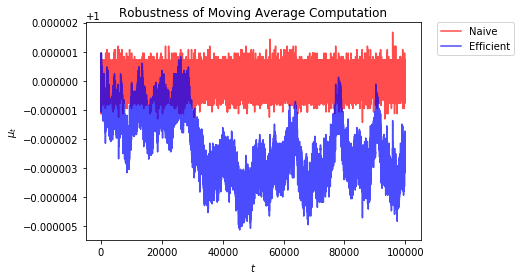

In [79]:
# mean, std, number of samples
mean = 10**0
stdDev = 10**-6
N = 100000
samples = normal(mean, stdDev, N).astype(float32)
K = 10

movingAvgNaive = MovAvgNaive(samples, K)
movingAvgEfficient = MovAvgEfficient(samples, K)

plt.plot(movingAvgNaive[K :-K], 'r', label="Naive", alpha=0.7)
plt.plot(movingAvgEfficient[K :-K], 'b', label="Efficient", alpha=0.7)
plt.xlabel('$t$')
plt.ylabel('$\mu_t$')
plt.title('Robustness of Moving Average Computation')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show();

In [80]:
samples = array([1, 2, 3, 4, 5, 6, 7])
movingAvg = MovAvgEfficient(samples, 3)

assert (movingAvg[6] - 6.0) < 1e-5


## Task 5 - Computing the variance of random samples

Our goal is to compute the variance of a large number of random samples $x_i$ drawn from a normal distribution, with variance $\sigma = 1$ and mean $\mu$. We compare two techniques for computing the variance from empirical samples.  

### The two loop method

This approach requires two separate loops. The first computes the sample mean:
$$\mu = \frac{1}{N}\displaystyle\sum\limits_{i=1}^N x_i ~,$$
and the second computes the variance:
$$\sigma_1^2 = \frac{1}{N-1}\displaystyle\sum\limits_{i=1}^N (x_i-\mu)^2~.$$
This approach is costly when the number of samples is high, but quite robust.

<font color='blue'>Your task is to **implement this two loop method**</font> 

In [83]:
def VarianceMeth1(samples, N):
    mu = float32(0)
    sigmaSq = float32(0)
  
    # YOUR CODE HERE
    summation = 0
    for sample in samples: 
        summation = summation + sample
    mu = float32(summation) / float32(N)
    
    summ_d = 0
    for sample in samples: 
        summ_d = summ_d + (sample - mu) * (sample - mu)
    sigmaSq = float32(summ_d) / float32(N - 1)
#     raise NotImplementedError()
    
    return sigmaSq

### The one loop method

This formulation computes the variance using only one loop by developing the square in the original formula and using properties of the mean:

$$\sigma_2^2 = \frac{1}{N-1}\left(\displaystyle\sum\limits_{i=1}^N x_i^2 - N\mu^2\right)$$

This approach is somewhat faster but it is less robust than its two loop counterpart. 

<font color='blue'>We provide you with the code for the one loop method. **`Run`** the following cell.</font>

In [84]:
def VarianceMeth2(samples, N):

  mu = float32(0)
  sampleSumSq = float32(0)
    
  for sample in  samples:
    mu += sample
    sampleSumSq += sample**2
  mu /= float32(N)
  
  sigmaSq = (sampleSumSq - float32(N)*mu**2)/float32(N-1)

  return sigmaSq

<font color='blue'>**`Run`** the following cell to compare the two approaches.</font>

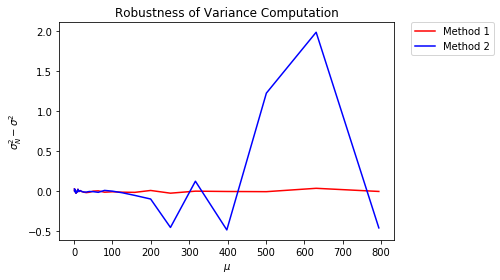

In [85]:
errorMeth1 = []
errorMeth2 = []

# means, std, number of samples
means = 10**arange(0.0, 3.0, 0.1)
stdDev = 10**0
variance = stdDev**2
N = 10000

for mean in means:
  samples = (normal(mean, stdDev, N)).astype(float32)

  # Method 1
  sigmaSq_1 = VarianceMeth1(samples, N)
  errorMeth1.append((variance-sigmaSq_1))

  # Method 2 (could be done in 1 loop instead of using sum)
  sigmaSq_2 = VarianceMeth2(samples, N)
  errorMeth2.append((variance-sigmaSq_2))

plt.plot(means, errorMeth1, 'r', label="Method 1")
plt.plot(means, errorMeth2, 'b', label="Method 2")
plt.xlabel('$\mu$')
plt.ylabel('$\sigma_N^2-\sigma^2$')
plt.title('Robustness of Variance Computation')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [ ]:
samples = arange(0, 10000, 1)
assert (VarianceMeth1(samples, samples.shape[0]) - 8334166) < 1e4